In [1]:
# Import
import numpy as np
import matplotlib.pyplot as plt
import pyart

# Read in baseline info
# (dbz95, clutterflag indices)
from netCDF4 import Dataset
dataset = Dataset('/home/hunzinger/data/rca_cluttermap_20181109.nc')
print(dataset.dimensions.keys())
print(dataset.variables.keys())
PCT_on_50 = dataset.variables['Flagged clutter grid gates'][:,:]
vPCT_on_50 = dataset.variables['Flagged clutter grid gates (V)'][:,:]
dataset.close()

print(PCT_on_50.shape)
#print(PCT_on_50[:,5])
#for i in range(0,len(PCT_on_50[:,0])):
#    for j in range(0,len(PCT_on_50[0,:])):
#        #print(i,0,'j = 0 is nan')
#        if np.isfinite(PCT_on_50[i,j]):
#            print(i,j,'FINITE NUMBER')


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119

odict_keys(['azi', 'rang', 'value'])
odict_keys(['Flagged clutter grid gates', 'Flagged clutter grid gates (V)'])
(360, 11)


In [2]:
def rca_create_baseline_netcdf(filename):
    '''Calculates the 95th percentile clutter area reflectivity baseline using clutter map'''
    from netCDF4 import Dataset
    dataset = Dataset('/home/hunzinger/data/rca_cluttermap_20181109.nc')
    PCT_on_50 = dataset.variables['Flagged clutter grid gates'][:,:]
    vPCT_on_50 = dataset.variables['Flagged clutter grid gates (V)'][:,:]
    dataset.close()
    
    radar = pyart.io.cfradial.read_cfradial(filename)
    date_time = radar.time['units'].replace('seconds since ', '')
    
    # Constrain range between 1 - 5 km
    r_start_idx = np.where(radar.range['data'] < 1000.)[0][-1]+1
    r_start_idx = 0
    r_stop_idx = np.where(radar.range['data'] > 10000.)[0][0]
    
    # Using lowest elevation angle of PPI (0.5 deg)
    sweep_start_idx = radar.sweep_start_ray_index['data'][0]
    sweep_stop_idx = radar.sweep_end_ray_index['data'][0]+1
    
    # Get variables (only the rays/gates needed)
    zh = radar.fields['reflectivity']['data'][sweep_start_idx:sweep_stop_idx,r_start_idx:r_stop_idx]
    zv = radar.fields['reflectivity_v']['data'][sweep_start_idx:sweep_stop_idx,r_start_idx:r_stop_idx]
    r = radar.range['data'][r_start_idx:r_stop_idx]
    theta = radar.azimuth['data'][sweep_start_idx:sweep_stop_idx]
    
    # Eliminate duplicate azimuths to maintain a total # of azimuths of 360
    if len(theta) > 360:
        diff = len(theta) - 360
        zh = np.delete(zh,-diff,axis=0)
        zv = np.delete(zv,-diff,axis=0)
        theta = np.delete(theta,-diff)
        
    # Arrange/sort azimuths to span 0 to 360 deg. from index 0 to 359
    sorted_idx = np.argsort(theta)
    zh = zh[sorted_idx]
    zv = zv[sorted_idx]
    theta = theta[sorted_idx]
    
    # Create array to store qualifying reflectivities (fall within PCT_on > 0.5)
    zh_car = np.empty((zh.shape))
    zh_car[:,:] = np.nan
    zv_car = np.empty((zv.shape))
    zv_car[:,:] = np.nan
    
    # Find and store all reflectivity values that fall within the PCT_on > 0.5 grid gate
    for i in range(0,len(PCT_on_50[:,0])):
        for j in range(0,len(PCT_on_50[0,:])):
            if np.isfinite(PCT_on_50[i,j]):
                zh_car[i,j*10-10:j*10] = zh[i,j*10-10:j*10]
                
    # Calculate the PDF of the clutter area reflectivity (CAR)
    mask = np.where(np.isfinite(zh_car))  
    n,bins,patches=plt.hist(zh_car[mask],bins=525,range=(-40.,65.))
    
    # Calculate CDF of clutter area reflectivity
    cdf = np.cumsum(n)
    p = cdf/cdf[-1]*100
    
    # Find coefficients of 13th degree polynomial for CDF
    x = np.arange(525)*(1/5)-40
    coeff = np.polyfit(p,x,13)
    poly_func = np.poly1d(coeff)
    #x_poly = np.linspace(p[0],p[-1],105)
    #y_poly = poly_func(x_poly)
    
    # Find the value of reflectivity at the 95th percentile of CDF
    dbz95 = poly_func(95.)
    
    # V POLARIZATION
    # Find and store all reflectivity values that fall within the PCT_on > 0.5 grid gate
    for i in range(0,len(vPCT_on_50[:,0])):
        for j in range(0,len(vPCT_on_50[0,:])):
            if np.isfinite(vPCT_on_50[i,j]):
                zv_car[i,j*10-10:j*10] = zv[i,j*10-10:j*10]
                
    # Calculate the PDF of the clutter area reflectivity (CAR)
    mask = np.where(np.isfinite(zv_car))  
    vn,vbins,vpatches=plt.hist(zv_car[mask],bins=525,range=(-40.,65.))
    
    # Calculate CDF of clutter area reflectivity
    cdf = np.cumsum(vn)
    vp = cdf/cdf[-1]*100
    
    # Find coefficients of 13th degree polynomial for CDF
    x = np.arange(525)*(1/5)-40
    coeff = np.polyfit(vp,x,13)
    poly_func = np.poly1d(coeff)
    #x_poly = np.linspace(p[0],p[-1],105)
    #y_poly = poly_func(x_poly)
    
    # Find the value of reflectivity at the 95th percentile of CDF
    dbz95_v = poly_func(95.)
    
    del radar
    return zh_car, date_time, n, bins, p, dbz95, PCT_on_50, zv_car, vn, vbins, vp, dbz95_v, vPCT_on_50


In [ ]:
# Run this function on a bunch of files (try data from one day)
import os
import glob

zh = []
dt = []
n = []
bins = []
cdf = []
p = []
dbz95 = []
PCT_on_50 = []
zv = []
vn = []
vbins = []
vp = []
dbz95_v = []
vPCT_on_50 = []

for f in glob.glob(os.path.join('/home/hunzinger/data/ppi_cf/', 'corcsapr2cfrppi*.20181109.*.nc')):
    print(f)
    ZH, DateTime, N, Bins, P, DBZ95, PCT, ZV, VN, VBins, VP, DBZ95V, VPCT = rca_create_baseline_netcdf(f)
    
    # Put all PPI times into a list
    zh.append(ZH)
    dt.append(DateTime)
    n.append(N)
    bins.append(Bins)
    p.append(P)
    dbz95.append(DBZ95)
    PCT_on_50.append(PCT)
    zv.append(ZV)
    vn.append(VN)
    vbins.append(VBins)
    vp.append(VP)
    dbz95_v.append(DBZ95V)
    vPCT_on_50.append(VPCT)

/home/hunzinger/data/ppi_cf/corcsapr2cfrppiM1.a1.20181109.133003.nc
/home/hunzinger/data/ppi_cf/corcsapr2cfrppiM1.a1.20181109.151503.nc
/home/hunzinger/data/ppi_cf/corcsapr2cfrppiM1.a1.20181109.010003.nc
/home/hunzinger/data/ppi_cf/corcsapr2cfrppiM1.a1.20181109.234503.nc
/home/hunzinger/data/ppi_cf/corcsapr2cfrppiM1.a1.20181109.054503.nc
/home/hunzinger/data/ppi_cf/corcsapr2cfrppiM1.a1.20181109.214503.nc
/home/hunzinger/data/ppi_cf/corcsapr2cfrppiM1.a1.20181109.171503.nc
/home/hunzinger/data/ppi_cf/corcsapr2cfrppiM1.a1.20181109.124503.nc
/home/hunzinger/data/ppi_cf/corcsapr2cfrppiM1.a1.20181109.223003.nc
/home/hunzinger/data/ppi_cf/corcsapr2cfrppiM1.a1.20181109.140003.nc
/home/hunzinger/data/ppi_cf/corcsapr2cfrppiM1.a1.20181109.001503.nc
/home/hunzinger/data/ppi_cf/corcsapr2cfrppiM1.a1.20181109.150003.nc
/home/hunzinger/data/ppi_cf/corcsapr2cfrppiM1.a1.20181109.213003.nc
/home/hunzinger/data/ppi_cf/corcsapr2cfrppiM1.a1.20181109.091503.nc
/home/hunzinger/data/ppi_cf/corcsapr2cfrppiM1.a1

50.89927171680049


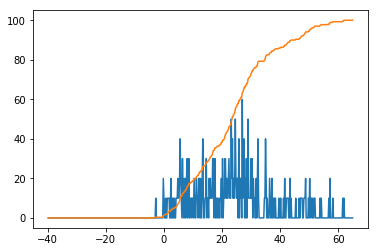

51.20424921023287


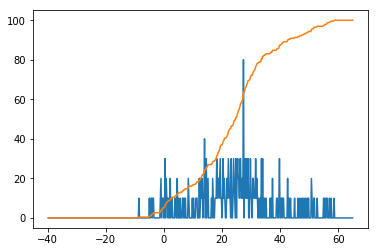

In [12]:
dbz95_baseline = np.nanmean(dbz95)
print(dbz95_baseline)

n = np.asarray(n)
bins = np.asarray(bins)
p = np.asarray(p)

n_baseline = np.nanmean(n,axis=0)
bins_baseline = bins[0,:]
p_baseline = np.nanmean(p,axis=0)

plt.plot(bins_baseline[1:],n_baseline*10)
plt.plot(bins_baseline[1:],p_baseline)
#plt.plot(x,p_baseline)
plt.show()

vdbz95_baseline = np.nanmean(dbz95_v)
print(vdbz95_baseline)

vn = np.asarray(vn)
vbins = np.asarray(vbins)
vp = np.asarray(vp)

vn_baseline = np.nanmean(vn,axis=0)
vbins_baseline = vbins[0,:]
vp_baseline = np.nanmean(vp,axis=0)

plt.plot(vbins_baseline[1:],vn_baseline*10)
plt.plot(vbins_baseline[1:],vp_baseline)
plt.show()
#plt.plot(x,p_baseline)

In [15]:
from netCDF4 import Dataset
dataset = Dataset('/home/hunzinger/data/rca_baseline_20181109.nc',
                  'w',format='NETCDF4_CLASSIC')

azi = dataset.createDimension('azi', 360)
rang = dataset.createDimension('rang', 11)
value = dataset.createDimension('value',1)
n = dataset.createDimension('nbins',525)
bins = dataset.createDimension('bins',526)

PCT_ON_50 = dataset.createVariable('Flagged clutter grid gates', np.float64, ('azi','rang'))
DBZ95_BASE = dataset.createVariable('Baseline 95th reflectivity', np.float64, ('value',))
N_BASE = dataset.createVariable('PDF counts', np.float64, ('nbins',))
BINS = dataset.createVariable('PDF bins', np.float64, ('bins',))
P_BASE = dataset.createVariable('CDF values', np.float64, ('nbins',))
VPCT_ON_50 = dataset.createVariable('Flagged clutter grid gates (V)', np.float64, ('azi','rang'))
VDBZ95_BASE = dataset.createVariable('Baseline 95th reflectivity (V)', np.float64, ('value',))
VN_BASE = dataset.createVariable('PDF counts (V)', np.float64, ('nbins',))
VBINS = dataset.createVariable('PDF bins (V)', np.float64, ('bins',))
VP_BASE = dataset.createVariable('CDF values (V)', np.float64, ('nbins',))

PCT_ON_50[:,:] = PCT_on_50[0]
DBZ95_BASE[:] = dbz95_baseline
N_BASE[:] = n_baseline
BINS[:] = bins_baseline
P_BASE[:] = p_baseline
VPCT_ON_50[:,:] = vPCT_on_50[0]
VDBZ95_BASE[:] = vdbz95_baseline
VN_BASE[:] = vn_baseline
VBINS[:] = vbins_baseline
VP_BASE[:] = vp_baseline

dataset.close()